## Welcome to Data Analysis in Apache Spark. We will analyze Sales Order Data.

### Load data into dataframe

In [1]:
df = spark.read.format("csv").option("header","false").load("Files/orders/2019.csv")
display(df)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 3, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f8597be0-6c93-47ef-9f96-94af1ef60cd5)

### Define data Schema

In [2]:
from pyspark.sql.types import *

orderSchema = StructType(
    [
        StructField("SalesOrderNumber", StringType()),
        StructField("SalesOrderLineNumber", IntegerType()),
        StructField("OrderDate", DateType()),
        StructField("CustomerName", StringType()),
        StructField("Email", StringType()),
        StructField("Item", StringType()),
        StructField("Quantity", IntegerType()),
        StructField("UnitPrice", FloatType()),
        StructField("Tax", FloatType()),

    ]
)


df = spark.read.format("csv").schema(orderSchema).load("Files/orders/*.csv")
display(df.limit(10))

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 918a6ad6-7097-4ae7-8cd8-b0fd8efc3149)

### Explore data in a dataframe

#### Filter a dataframe

In [3]:
customers = df["CustomerName", "Email"]
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 5, Finished, Available, Finished)

32718
12427


SynapseWidget(Synapse.DataFrame, d6edb948-bc3e-4575-b72f-e33048527e20)

In [4]:
customers = df.select("CustomerName", "Email").where(df['Item'] == 'Road-250 Red, 52')
print(customers.count())
print(customers.distinct().count())
display(customers.distinct())

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 6, Finished, Available, Finished)

133
133


SynapseWidget(Synapse.DataFrame, bb377941-36f7-42fe-87a0-1c3a613f1195)

#### Aggregate and group data in a dataframe

In [5]:
productSales = df.select("Item", "Quantity").groupBy("Item").sum()
display(productSales)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 78c73754-f864-43e9-b4c6-7e94adf498cb)

In [6]:
from pyspark.sql.functions import *

yearlySales = df.select(year(col("OrderDate")).alias("Year")).groupBy("Year").count().orderBy("Year")
display(yearlySales)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 93506fe7-a053-4ec9-8ff0-39e21e2f589b)

#### Ingest data in a particular format or structure, and transform it for further downstream processing or analysis.

- Add Year and Month columns based on the OrderDate column.
- Add FirstName and LastName columns based on the CustomerName column.
- Filter and reorder the columns, removing the CustomerName column.

In [7]:
# create a year and month columns
transformed_df = df.withColumn("Year", year(col("OrderDate"))).withColumn("Month", month(col("OrderDate")))

# create the new FirstName and LastName fields
transformed_df = transformed_df.withColumn("FirstName", split(col("CustomerName"), " ").getItem(0)).withColumn("LastName", split(col("CustomerName"), " ").getItem(1))

# Filter and reorder columns
transformed_df = transformed_df["SalesOrderNumber", "SalesOrderLineNumber", "OrderDate", "Year", "Month", "FirstName", "LastName", "Email", "Item", "Quantity", "UnitPrice", "Tax"]

# Display the first five orders
display(transformed_df.limit(5))


StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 9, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, ca8e0a6b-878a-4fe1-9ce0-63c6dda4878e)

In [8]:
transformed_df.write.mode("overwrite").parquet("Files/transformed_data/orders")
print("Saved!")

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 10, Finished, Available, Finished)

Saved!


In [9]:
orders_df = spark.read.format("parquet").load("Files/transformed_data/orders")
display(orders_df.limit(10))

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c89e954c-4532-44e4-b7d9-0ef951825085)

In [10]:
# orders_2021_df = spark.read.format("parquet").load("Files/partitioned_data/Year=2021/Month=*")
# display(orders_2021_df)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 12, Finished, Available, Finished)

## Work with tables and SQL

### Create Tables

In [13]:
# create a new table
df.write.format("delta").mode("overwrite").saveAsTable("salesorders")

# get the table description
spark.sql("DESCRIBE EXTENDED salesorders").show(truncate=False)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 15, Finished, Available, Finished)

+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                            |comment|
+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------+-------+
|SalesOrderNumber            |string                                                                                                                               |null   |
|SalesOrderLineNumber        |int                                                                                                                                  |null   |
|OrderDate                   |date                                                                                                     

In [14]:

# With Spark SQL, Please run the query onto the lakehouse which is from the same workspace as the current default lakehouse.

df = spark.sql("SELECT * FROM fabric_labs_lakehouse.salesorders LIMIT 10")
display(df)

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 16, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 9fc1b28b-af41-487f-8fde-c2ee85d5056d)

<!-- ## Work with tables and SQL -->

In [15]:
%%sql
SELECT YEAR(OrderDate) AS OrderYear,
       SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue
FROM salesorders
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear;

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 17, Finished, Available, Finished)

<Spark SQL result set with 3 rows and 2 fields>

### Visualize data with Spark

In [16]:
%%sql
SELECT * FROM salesorders


StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 18, Finished, Available, Finished)

<Spark SQL result set with 1000 rows and 9 fields>

In [18]:
sqlQuery = "SELECT  CAST(YEAR(OrderDate) as CHAR(4)) AS OrderYear, \
        SUM((UnitPrice * Quantity) + Tax) AS GrossRevenue \
        FROM salesorders \
        GROUP BY CAST(YEAR(OrderDate) AS CHAR(4)) \
        ORDER BY OrderYear"

df_spark = spark.sql(sqlQuery)
df_spark.show()

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 20, Finished, Available, Finished)

+---------+--------------------+
|OrderYear|        GrossRevenue|
+---------+--------------------+
|     2019|   4172169.969970703|
|     2020|   6882259.268127441|
|     2021|1.1547835291696548E7|
+---------+--------------------+



StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 29, Finished, Available, Finished)

<Figure size 640x480 with 0 Axes>

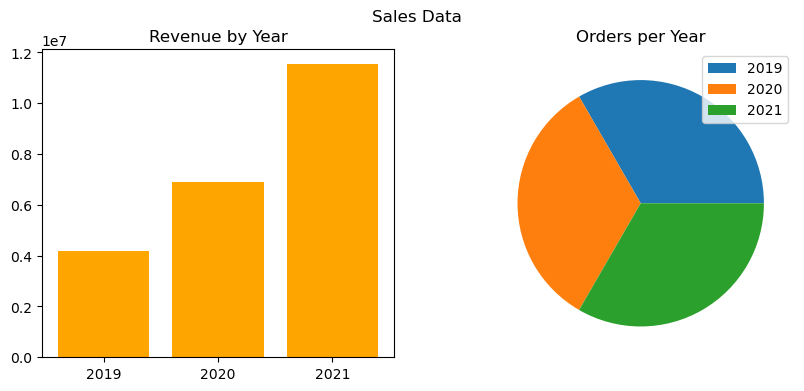

In [27]:
from matplotlib import pyplot as plt 

plt.clf()

fig, ax = plt.subplots(1,2, figsize = (10,4))

df_sales = df_spark.toPandas()
yearly_counts = df_sales['OrderYear'].value_counts()

ax[0].bar(x = df_sales['OrderYear'], height=df_sales['GrossRevenue'], color='orange')
ax[0].set_title('Revenue by Year')
ax[1].pie(yearly_counts)
ax[1].set_title('Order Per Year')
# customize the chart

ax[1].set_title('Orders per Year')
ax[1].legend(yearly_counts.keys().tolist())

# Add a title to the Figure
fig.suptitle('Sales Data')

plt.show()

### Using seaborn library

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 30, Finished, Available, Finished)

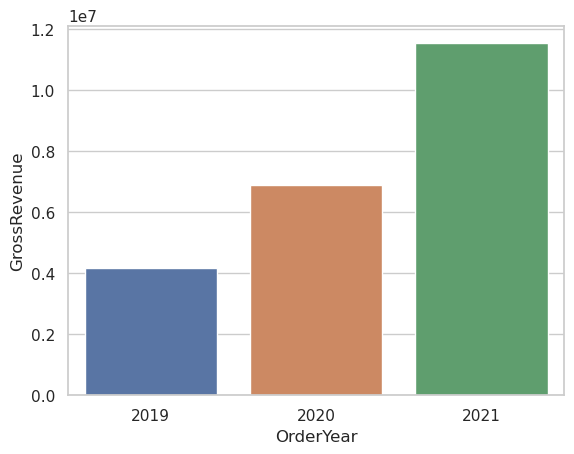

In [28]:
import seaborn as sns

# Clear the plot area
plt.clf()

# Set the visual theme for seaborn
sns.set_theme(style="whitegrid")

# Create a bar chart
ax = sns.barplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()

StatementMeta(, d8f79b22-4161-4c2a-8d93-f53a850fc582, 31, Finished, Available, Finished)

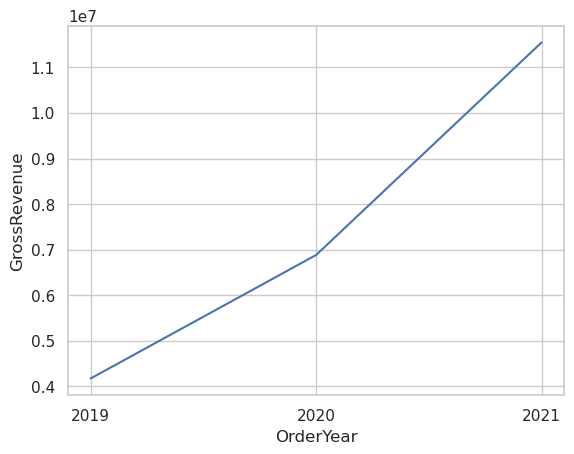

In [29]:
# Clear the plot area
plt.clf()

# Create a line chart
ax = sns.lineplot(x="OrderYear", y="GrossRevenue", data=df_sales)
plt.show()